# Introducción al Desarrollo de Software Cuántico - Trabajo Final

* Alumno: Ing. Oscar Agustín Stanchi
  * Doctorando en Ciencias Informáticas - Facultad de Informática (UNLP)

# 0. Configuración

In [ ]:
%%capture
!pip install qiskit
!pip install qiskit-algorithms
!pip install qiskit-machine-learning
!pip install pylatexenc

In [ ]:
import os
import pickle
import math

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

In [ ]:
SEED = 42
np.random.seed(SEED); algorithm_globals.random_seed = SEED

# 1. Introducción

Las Redes Neuronales Convolucionales Cuánticas (QCNNs, por sus siglas en inglés) fueron propuestas por primera vez por Cong et al. <a name="cite_ref-1"></a>[[1]](#cite_note-1). En este trabajo se realizará la implementación de lo que respectan las capas convolucionales y de agrupamiento utilizando un circuito cuántico en Qiskit.

## 1.1 Redes Neuronales Convolucionales Clásicas

Las Redes Neuronales Convolucionales Clásicas (CCNNs, por sus siglas en inglés) son un tipo de red neuronal artificial que sobresale en la identificación de características y patrones específicos dentro de los datos de entrada. La capa convolucional en el nivel $l^{th}$ detecta estas características a través del plano $ij$ y asocia cada patrón con una clase correspondiente, como se ilustra en la **Figura 1**.

Una capa de agrupamiento (pooling) en una CCNN reduce la dimensionalidad de los datos de entrada, lo que ayuda a disminuir el costo computacional y el número de parámetros de aprendizaje.

![](https://i.ibb.co/rFPSw1f/classical-cnn.png)

**Figura 1.** Esquema de una CCNN utilizada para clasificar imágenes de un gato y un perro. Las capas convolucionales y de agrupamiento reducen las dimensiones de la imagen, y la salida final clasifica la imagen como un gato o un perro. Fuente de la imagen: <a name="cite_ref-1"></a>[[1]](#cite_note-1).


## 1.2 Redes Neuronales Convolucionales Cuánticas

Las QCNNs operan de manera similar a las CCNNs. El proceso comienza codificando una imagen pixelada en un circuito de estado cuántico utilizando un mapa de características, como el `ZFeatureMap` o el `ZZFeatureMap` de Qiskit.

Una vez que la imagen está codificada en el estado cuántico $ \left| \psi \right\rangle $, se transforma y se extraen las características utilizando capas cuánticas convolucionales y de agrupamiento <a name="cite_ref-4"></a>[[4]](#cite_note-4). Las transformaciones se aplican alternando capas convolucionales y de agrupamiento para reducir la dimensionalidad del circuito hasta que quede solo un qubit. Este qubit final se mide para clasificar la imagen de entrada. Esto se muestra en la **Figura 2**.

La **Capa Convolucional Cuántica** consiste en [operadores unitarios](https://es.wikipedia.org/wiki/Operador_unitario) de dos qubits que detectan relaciones entre los qubits en el circuito y son *invariantes a las traslaciones*. A diferencia del agrupamiento clásico, la **Capa de Agrupamiento Cuántico** reduce el número de qubits al descartar selectivamente ciertos qubits en capas específicas.

Cada capa de la QCNN contiene circuitos parametrizados, donde ajustar los parámetros ayuda a minimizar la función de pérdida durante el entrenamiento, mejorando así el rendimiento de la red.

![](https://i.ibb.co/GFDVdhp/quantum-cnn.png)

**Figura 2.** Ejemplo de una QCNN de cuatro qubits. La primera capa convolucional opera sobre todos los qubits. La primera capa de agrupamiento reduce la dimensionalidad de cuatro qubits a dos al descartar los dos primeros. La segunda capa convolucional detecta características entre los dos qubits restantes, seguida de una segunda capa de agrupamiento que reduce la dimensionalidad a un qubit, que es el qubit de salida. Fuente de la imagen: <a name="cite_ref-2"></a>[[2]](#cite_note-2).


# 2. Datos

Una aplicación común de las CCNNs es la clasificación de imágenes, donde la red detecta características específicas (como líneas o curvas) en imágenes pixeladas utilizando mapas de características (feature maps) en las capas convolucionales. Al aprender las relaciones entre estas características, las CCNNs pueden clasificar imágenes.

Dada la capacidad de las CCNNs para identificar patrones, se entrenará la QCNN para detectar características en la base de datos MNIST (Modified National Institute of Standards and Technology) de LeCun et al. <a name="cite_ref-3"></a>[[3]](#cite_note-3), un conjunto de imágenes pixeladas de dígitos escritos a mano. Se obtuvo el conjunto de datos de las colecciones de acceso público proporcionadas por TensorFlow. El enfoque de este trabajo está basado en los experimentos realizados por Lü et al. <a name="cite_ref-4"></a>[[4]](#cite_note-4) y Oh et al. <a name="cite_ref-10"></a>[[10]](#cite_note-10).

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
x_train.shape, x_test.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
x_train.max(), x_train.min(), x_test.max(), x_test.min()

(1.0, 0.0, 1.0, 0.0)

Para este experimento, se tienen en consideración únicamente los dígitos 3 y 6, ya que son fácilmente diferenciables entre las 10 clases del conjunto de datos. Además, para simplificar aún más, se reduce la dimensionalidad de las imágenes a $4 \times 4$ píxeles. También se reduce el tamaño del conjunto de datos eliminando duplicados y datos conflictivos que resultan de estas simplificaciones.

Para el etiquetado, se asigna a las imágenes con un 3 la etiqueta de 1, y a las imágenes con un 6 la etiqueta de -1, de modo que la QCNN pueda aprender a diferenciar entre los dos patrones. Finalmente, se divide el conjunto de datos en entrenamiento y prueba, seleccionando solo 50 imágenes para el entrenamiento y 10 imágenes para la prueba, con el fin de entrenar y evaluar la QCNN.


In [ ]:
def filter_classes(x_data, y_data, classes: tuple[int,int]):
    n1,n2=classes
    keep = (y_data == n1) | (y_data == n2)
    x_data, y_data = x_data[keep], y_data[keep]
    y_data = (y_data == n1)
    return x_data,y_data

In [ ]:
classes=(3,6)
(x_train_filtered, y_train_filtered), (x_test_filtered, y_test_filtered) = filter_classes(x_train, y_train, classes), filter_classes(x_test, y_test, classes)
x_train_filtered.shape, x_test_filtered.shape

((12049, 28, 28, 1), (1968, 28, 28, 1))

Text(0.5, 1.0, 'True')

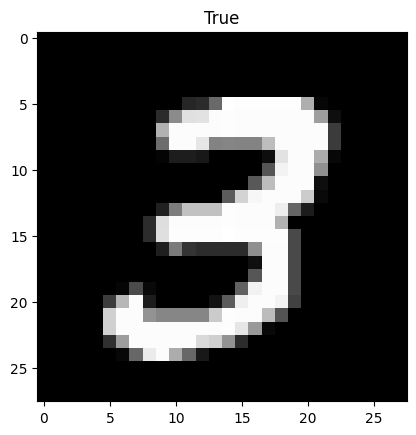

In [ ]:
idx=0
plt.imshow(x_train_filtered[idx, :, :, 0], cmap='gray')
plt.title(y_train_filtered[idx])

In [ ]:
size=(4,4)
n_qubits=size[0]*size[1]
x_train_small, x_test_small = tf.image.resize(x_train_filtered, size).numpy(), tf.image.resize(x_test_filtered, size).numpy()

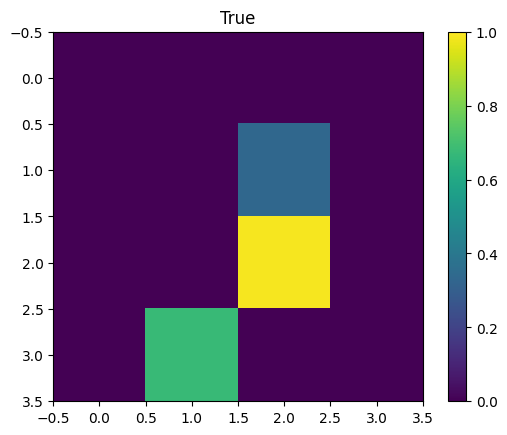

In [ ]:
plt.imshow(x_train_small[idx,:,:,0], vmin=0, vmax=1)
plt.title(y_train_filtered[idx])
plt.colorbar()

In [ ]:
# THRESHOLD = 0.5

# x_train_binary, x_test_binary = np.array(x_train_small > THRESHOLD, dtype=np.float32), np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [ ]:
x_train_binary, x_test_binary = x_train_small, x_test_small

In [ ]:
def remove_duplicates(x_data,y_data):
    final = {}
    duplicates = []
    for x,y in zip(x_data,y_data):
        key = tuple(x.flatten())
        if key in final:
            duplicates.append(key)
        else:
            final[key] = y
    for key in set(duplicates):
        del final[key]
        # print(np.array(key).reshape(*size,1))

    return np.array(list(final.keys())).reshape(-1,*size,1), np.array(list(final.values()))

In [ ]:
(x_train_clean, y_train_clean), (x_test_clean, y_test_clean) = remove_duplicates(x_train_binary, y_train_filtered), remove_duplicates(x_test_binary, y_test_filtered)
x_train_clean.shape, y_train_clean.shape, x_test_clean.shape, y_test_clean.shape

((9895, 4, 4, 1), (9895,), (1749, 4, 4, 1), (1749,))

In [ ]:
def get_random_subset(x, y, n):
    n1_indices = np.where(y == True)[0]
    n2_indices = np.where(y == False)[0]

    n1_sample_indices = np.random.choice(n1_indices, n, replace=False)
    n2_sample_indices = np.random.choice(n2_indices, n, replace=False)

    selected_indices = np.concatenate([n1_sample_indices, n2_sample_indices])
    np.random.shuffle(selected_indices)

    x_subset = x[selected_indices]
    y_subset = y[selected_indices]

    return x_subset, y_subset

In [ ]:
(x_train_subset, y_train_subset), (x_test_subset, y_test_subset) = get_random_subset(x_train_clean, y_train_clean, 25), get_random_subset(x_test_clean, y_test_clean, 5)
x_train_subset.shape, y_train_subset.shape, x_test_subset.shape, y_test_subset.shape

((50, 4, 4, 1), (50,), (10, 4, 4, 1), (10,))

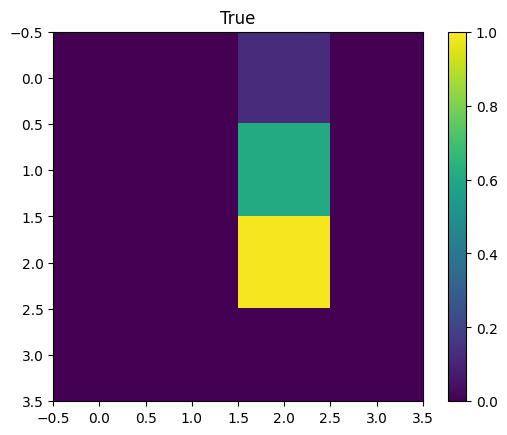

In [ ]:
plt.imshow(x_train_subset[idx,:,:,0], vmin=0, vmax=1)
plt.title(y_train_subset[idx])
plt.colorbar()

In [ ]:
x_train_flatten, x_test_flatten = x_train_subset.reshape(x_train_subset.shape[0], -1), x_test_subset.reshape(x_test_subset.shape[0], -1)
x_train_flatten.shape, x_test_flatten.shape

((50, 16), (10, 16))

In [ ]:
train_unique_batches, test_unique_batches = np.unique(x_train_flatten, axis=0), np.unique(x_test_flatten, axis=0)

assert train_unique_batches.shape[0] == x_train_flatten.shape[0], "There are duplicate elements among the batches of train data"
assert test_unique_batches.shape[0] == x_test_flatten.shape[0], "There are duplicate elements among the batches of test data"

In [ ]:
# change data target to 1 or -1
y_train_subset, y_test_subset = 2*y_train_subset-1, 2*y_test_subset-1

In [ ]:
np.unique(y_train_subset, return_counts=True), np.unique(y_test_subset, return_counts=True)

((array([-1,  1]), array([25, 25])), (array([-1,  1]), array([5, 5])))

Dado que las imágenes en el conjunto de datos tienen 16 píxeles, se utilizan 16 qubits en la QCNN. Para codificar el conjunto de datos, se aplica un `ZFeatureMap`.

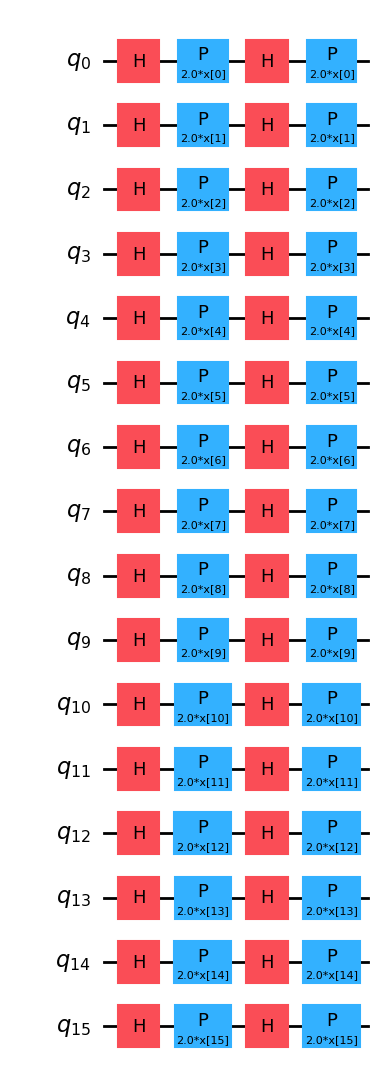

In [ ]:
feature_map = ZFeatureMap(n_qubits)
feature_map.decompose().draw("mpl", style="iqp")

# 3. Modelo

La fuente de datos cuánticos utilizada es un cluster state <a name="cite_ref-5"></a>[[5]](#cite_note-5), que puede o no tener una excitación. La QCNN aprenderá a detectar esta excitación. Se entrena un clasificador cuántico para determinar si el estado está "excitado" o no. Aunque el cluster state está altamente entrelazado, no es necesariamente difícil para una computadora clásica manejarlo.

Para esta tarea de clasificación, se utiliza una arquitectura *profunda* tipo **MERA** <a name="cite_ref-6"></a>[[6]](#cite_note-6) como backbone de la QCNN, ya que:

- Al igual que la QCNN, el cluster state es invariante a traslaciones.
- El cluster state está altamente entrelazado.
- Esta arquitectura reduce efectivamente el entrelazamiento, con el resultado de la clasificación obtenido mediante la medición de un único qubit.


## 3.1 Cluster State

Un cluster state "excitado" se define como aquel en el que se ha aplicado una puerta $R_X$ a cualquiera de sus qubits. El flujo de trabajo descrito se muestra en la **Figura 3**.

![](https://i.ibb.co/FWzjsGP/qcnn-cirq.png)

**Figura 3.** Flujo de trabajo para entrenar una QCNN para detectar excitación en un cluster state. El proceso comienza con el bloque "Prepare Cluster State", seguido del bloque "Excite or Not" donde se aplica la excitación. A continuación, se aplican alternativamente capas Cuánticas Convolucionales (Qconv) y de Agrupamiento Cuántico (Qpool) dos veces para reducir la dimensionalidad. Finalmente, se mide el último qubit para determinar si el estado de clúster está "excitado" o no. Fuente de la imagen: <a name="cite_ref-11"></a>[[11]](#cite_note-11).



In [ ]:
def cluster_state_circuit(n_qubits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = QuantumCircuit(n_qubits, name="cluster_state_circuit")
    bits = range(n_qubits)
    circuit.h(bits)
    bits = list(bits)
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.cz(this_bit, next_bit)
    return circuit

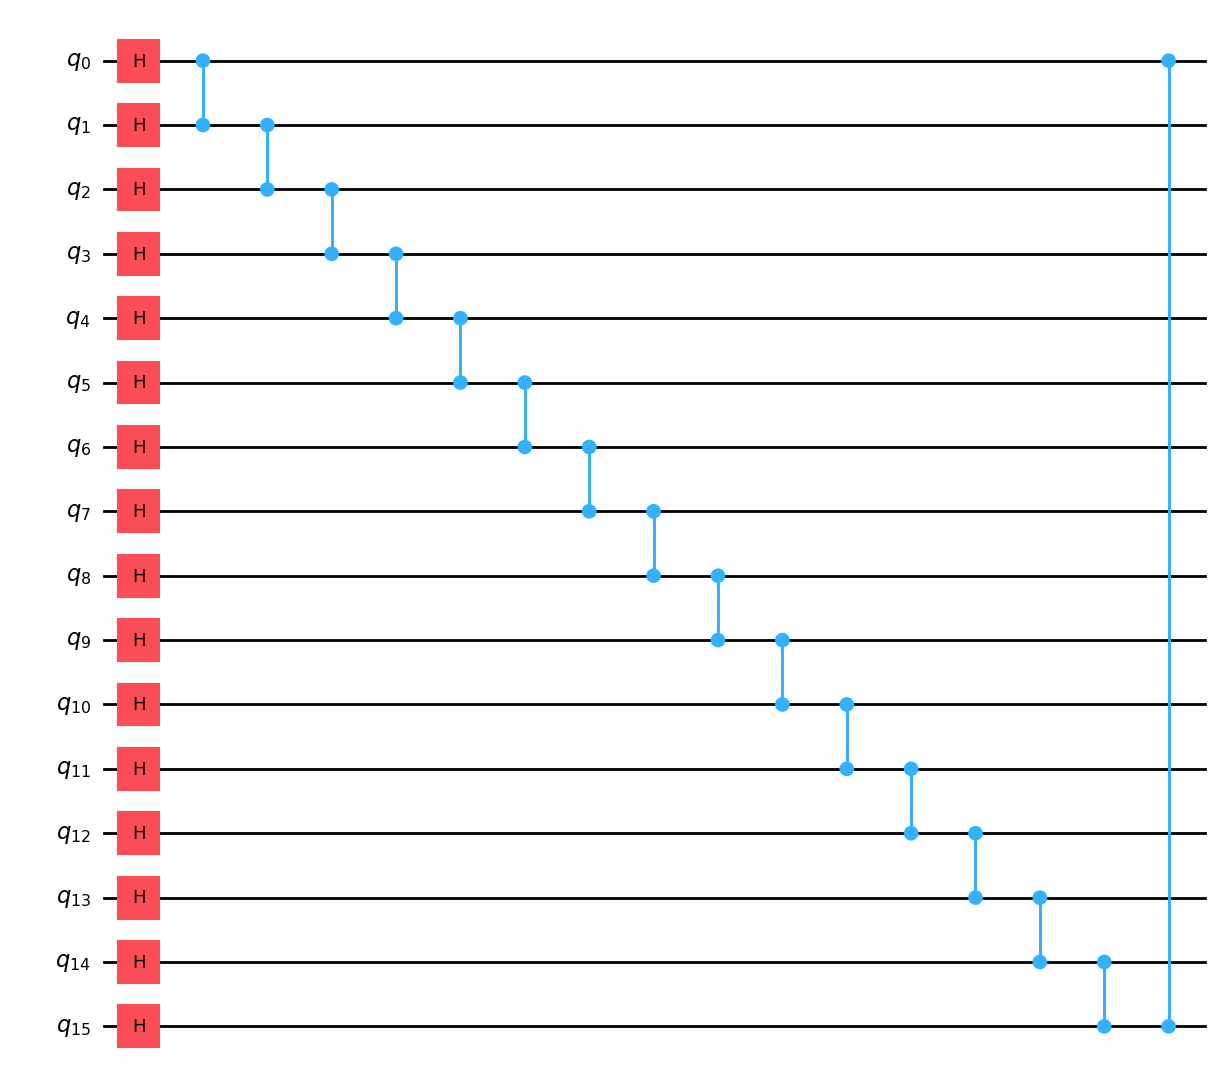

In [ ]:
circuit = cluster_state_circuit(n_qubits)
circuit.draw("mpl", style="iqp")

## 3.2 Capas de la QCNN

Dado que las capas que constituyen el modelo se definen según el enfoque descrito en el artículo de Cong et al. <a name="cite_ref-1"></a>[[1]](#cite_note-1) sobre QCNN, se requieren los siguientes prerrequisitos:

- Las matrices unitarias parametrizadas de uno y dos qubits, tal como se describe en el artículo de Tucci <a name="cite_ref-7"></a>[[7]](#cite_note-7).
- Una operación general de agrupamiento parametrizada de dos qubits.



In [ ]:
def one_qubit_unitary(bit, params):
    """Make a circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `params`."""
    circuit = QuantumCircuit(1)
    circuit.rx(params[0], bit)  # Rotation around the X axis
    circuit.ry(params[1], bit)  # Rotation around the Y axis
    circuit.rz(params[2], bit)  # Rotation around the Z axis
    return circuit

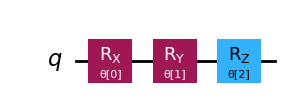

In [ ]:
params = ParameterVector('θ', length=3)
bit = 0
circuit = one_qubit_unitary(bit, params)
circuit.draw("mpl", style="iqp")

In [ ]:
def two_qubit_unitary(bits, params):
    """Make a circuit that creates an arbitrary two qubit unitary."""
    circuit = QuantumCircuit(2)
    # Apply single-qubit unitary to the first qubit
    circuit.compose(one_qubit_unitary(0, params[0:3]), qubits=[0], inplace=True)
    # Apply single-qubit unitary to the second qubit
    circuit.compose(one_qubit_unitary(0, params[3:6]), qubits=[1], inplace=True)
    # Apply ZZ, YY, XX gates with parameters
    circuit.rzz(params[6], bits[0], bits[1])
    circuit.ryy(params[7], bits[0], bits[1])
    circuit.rxx(params[8], bits[0], bits[1])
    # Apply another layer of single-qubit unitaries to each qubit
    circuit.compose(one_qubit_unitary(0, params[9:12]), qubits=[0], inplace=True)
    circuit.compose(one_qubit_unitary(0, params[12:15]), qubits=[1], inplace=True)
    return circuit

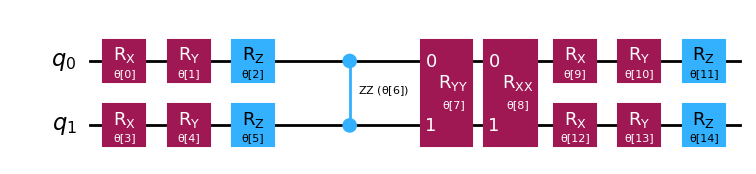

In [ ]:
params = ParameterVector('θ', length=15)
circuit = two_qubit_unitary([0, 1], params)
circuit.draw("mpl", style="iqp")

In [ ]:
def two_qubit_pool(source_qubit, sink_qubit, params):
    """Make a circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    circuit = QuantumCircuit(2)
    # Basis selection on the sink qubit
    sink_basis_selector = one_qubit_unitary(0, params[0:3])
    # Basis selection on the source qubit
    source_basis_selector = one_qubit_unitary(0, params[3:6])

    # Add the operations to the circuit
    circuit.compose(sink_basis_selector, qubits=[sink_qubit], inplace=True)
    circuit.compose(source_basis_selector, qubits=[source_qubit], inplace=True)
    circuit.cx(source_qubit, sink_qubit)
    # Apply the inverse of the basis selector on the sink qubit
    circuit.compose(sink_basis_selector.inverse(), qubits=[sink_qubit], inplace=True)
    return circuit

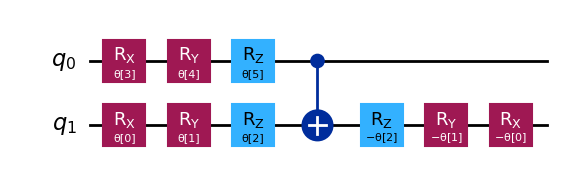

In [ ]:
params_pool = ParameterVector('θ', length=6)
circuit_pool = two_qubit_pool(0, 1, params_pool)
circuit_pool.draw("mpl", style="iqp")

## 3.3 Convolución Cuántica

Siguiendo el enfoque de Cong et al. <a name="cite_ref-1"></a>[[1]](#cite_note-1), la convolución cuántica 1D se define como la aplicación de una matriz unitaria parametrizada de dos qubits a cada par de qubits adyacentes, con un paso (stride) de uno.

In [ ]:
def quantum_conv_circuit(bits, params):
    """Quantum convolution layer applying `two_qubit_unitary` to pairs of qubits in `bits`."""
    num_qubits = len(bits)
    circuit = QuantumCircuit(num_qubits, name="Convolutional Layer")

    # Apply `two_qubit_unitary` to pairs of qubits in the first pass
    for first, second in zip(bits[0::2], bits[1::2]):
        two_qubit_unitary_circuit = two_qubit_unitary([0, 1], params)
        circuit.compose(two_qubit_unitary_circuit, qubits=[first, second], inplace=True)

    # Apply `two_qubit_unitary` to offset pairs in the second pass
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        two_qubit_unitary_circuit = two_qubit_unitary([0, 1], params)
        circuit.compose(two_qubit_unitary_circuit, qubits=[first, second], inplace=True)

    qc_inst = circuit.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))

    return qc

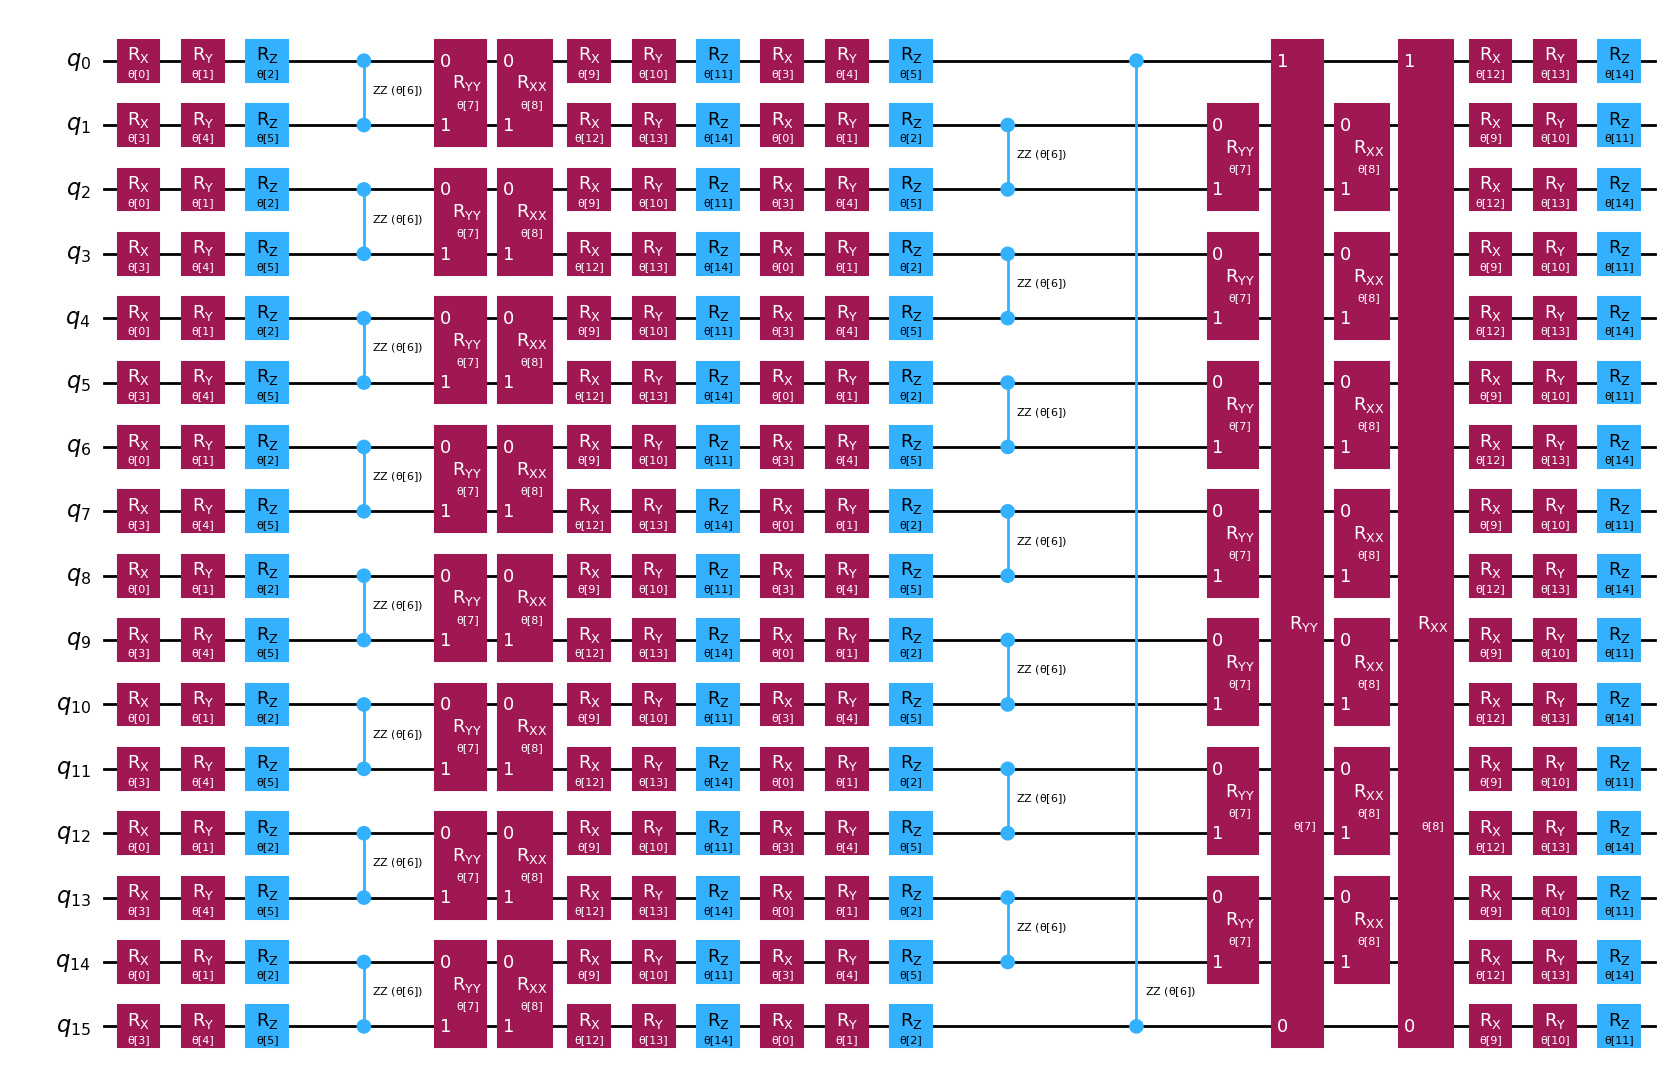

In [ ]:
params = ParameterVector('θ', length=15)
circuit = quantum_conv_circuit(list(range(n_qubits)), params)
circuit.decompose().draw("mpl", style="iqp")

## 3.4 Agrupamiento Cuántico

Una capa de agrupamiento cuántico reduce el número de qubits de $N$ qubits a $\frac{N}{2}$ qubits mediante la aplicación de la operación de agrupamiento de dos qubits definida anteriormente.

In [ ]:
def quantum_pool_circuit(source_bits, sink_bits, params):
    """Quantum pooling layer applying `two_qubit_pool` to pairs of qubits.
    Tries to learn to pool the relevant information from N qubits onto N/2."""
    num_qubits = max(max(source_bits), max(sink_bits)) + 1
    circuit = QuantumCircuit(num_qubits, name="Pooling Layer")

    # Apply `two_qubit_pool` to each pair of qubits in source and sink
    for source, sink in zip(source_bits, sink_bits):
        two_qubit_pool_circuit = two_qubit_pool(0, 1, params)
        circuit.compose(two_qubit_pool_circuit, qubits=[source, sink], inplace=True)

    qc_inst = circuit.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))

    return qc

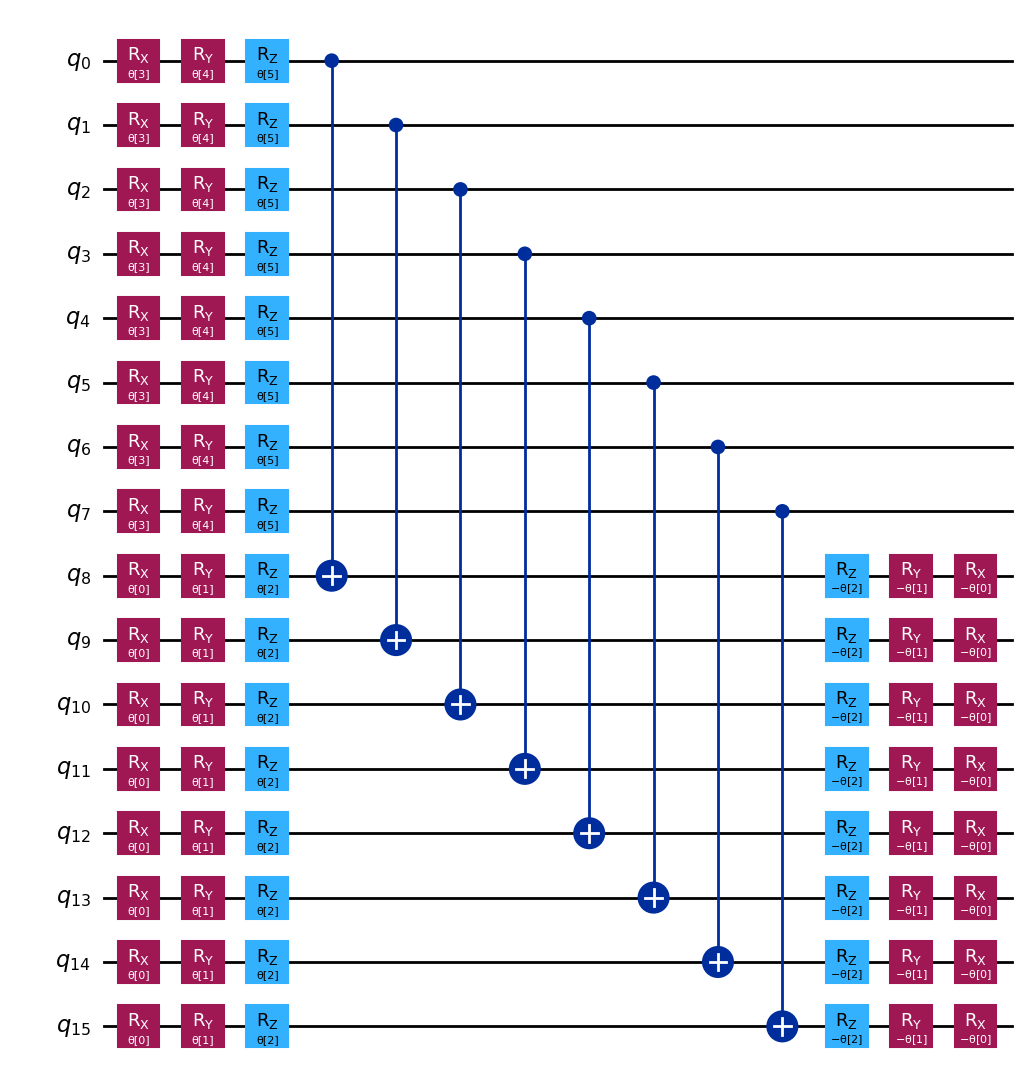

In [ ]:
params = ParameterVector('θ', length=6)
test_bits_source = list(range(n_qubits//2))
test_bits_sink = list(range(n_qubits//2, n_qubits))
circuit = quantum_pool_circuit(test_bits_source, test_bits_sink, params)
circuit.decompose().draw("mpl", style="iqp")

## 3.5 Ansatz Cuántico

Usando las capas definidas, se construye un [*ansatz*](https://es.wikipedia.org/wiki/Ansatz) de la QCNN. La QCNN constará de cuatro conjuntos de capas alternadas de convolución y agrupamiento. Se comienza con 16 qubits, se aplican agrupamientos para reducirlos a uno, y luego se mide el último qubit $\langle \hat{Z} \rangle$.


In [ ]:
def quantum_ansatz(n_qubits):
    """Create sequence of alternating convolution and pooling operators
    which gradually shrink over time."""
    # Create the ansatz using convolution and pooling functions
    ansatz = QuantumCircuit(n_qubits, name="Ansatz")
    n_layers = int(math.log2(n_qubits))
    n_params = n_layers * 15 + n_layers * 6
    params = ParameterVector('θ', length=n_params)
    conv_qubits = list(range(n_qubits))
    param_idx = 0
    for i in range(n_layers):
        bits = list(range(len(conv_qubits)))
        ansatz.compose(
            quantum_conv_circuit(bits, params[param_idx:param_idx+15]),
            conv_qubits,
            inplace=True)
        param_idx += 15
        pool_qubits_source, pool_qubits_sink = conv_qubits[:len(conv_qubits)//2], conv_qubits[len(conv_qubits)//2:]
        ansatz.compose(quantum_pool_circuit(bits[:len(bits)//2], bits[len(bits)//2:], params[param_idx:param_idx+6]),
                       conv_qubits,
                       inplace=True)
        param_idx += 6
        conv_qubits=pool_qubits_sink
    return ansatz

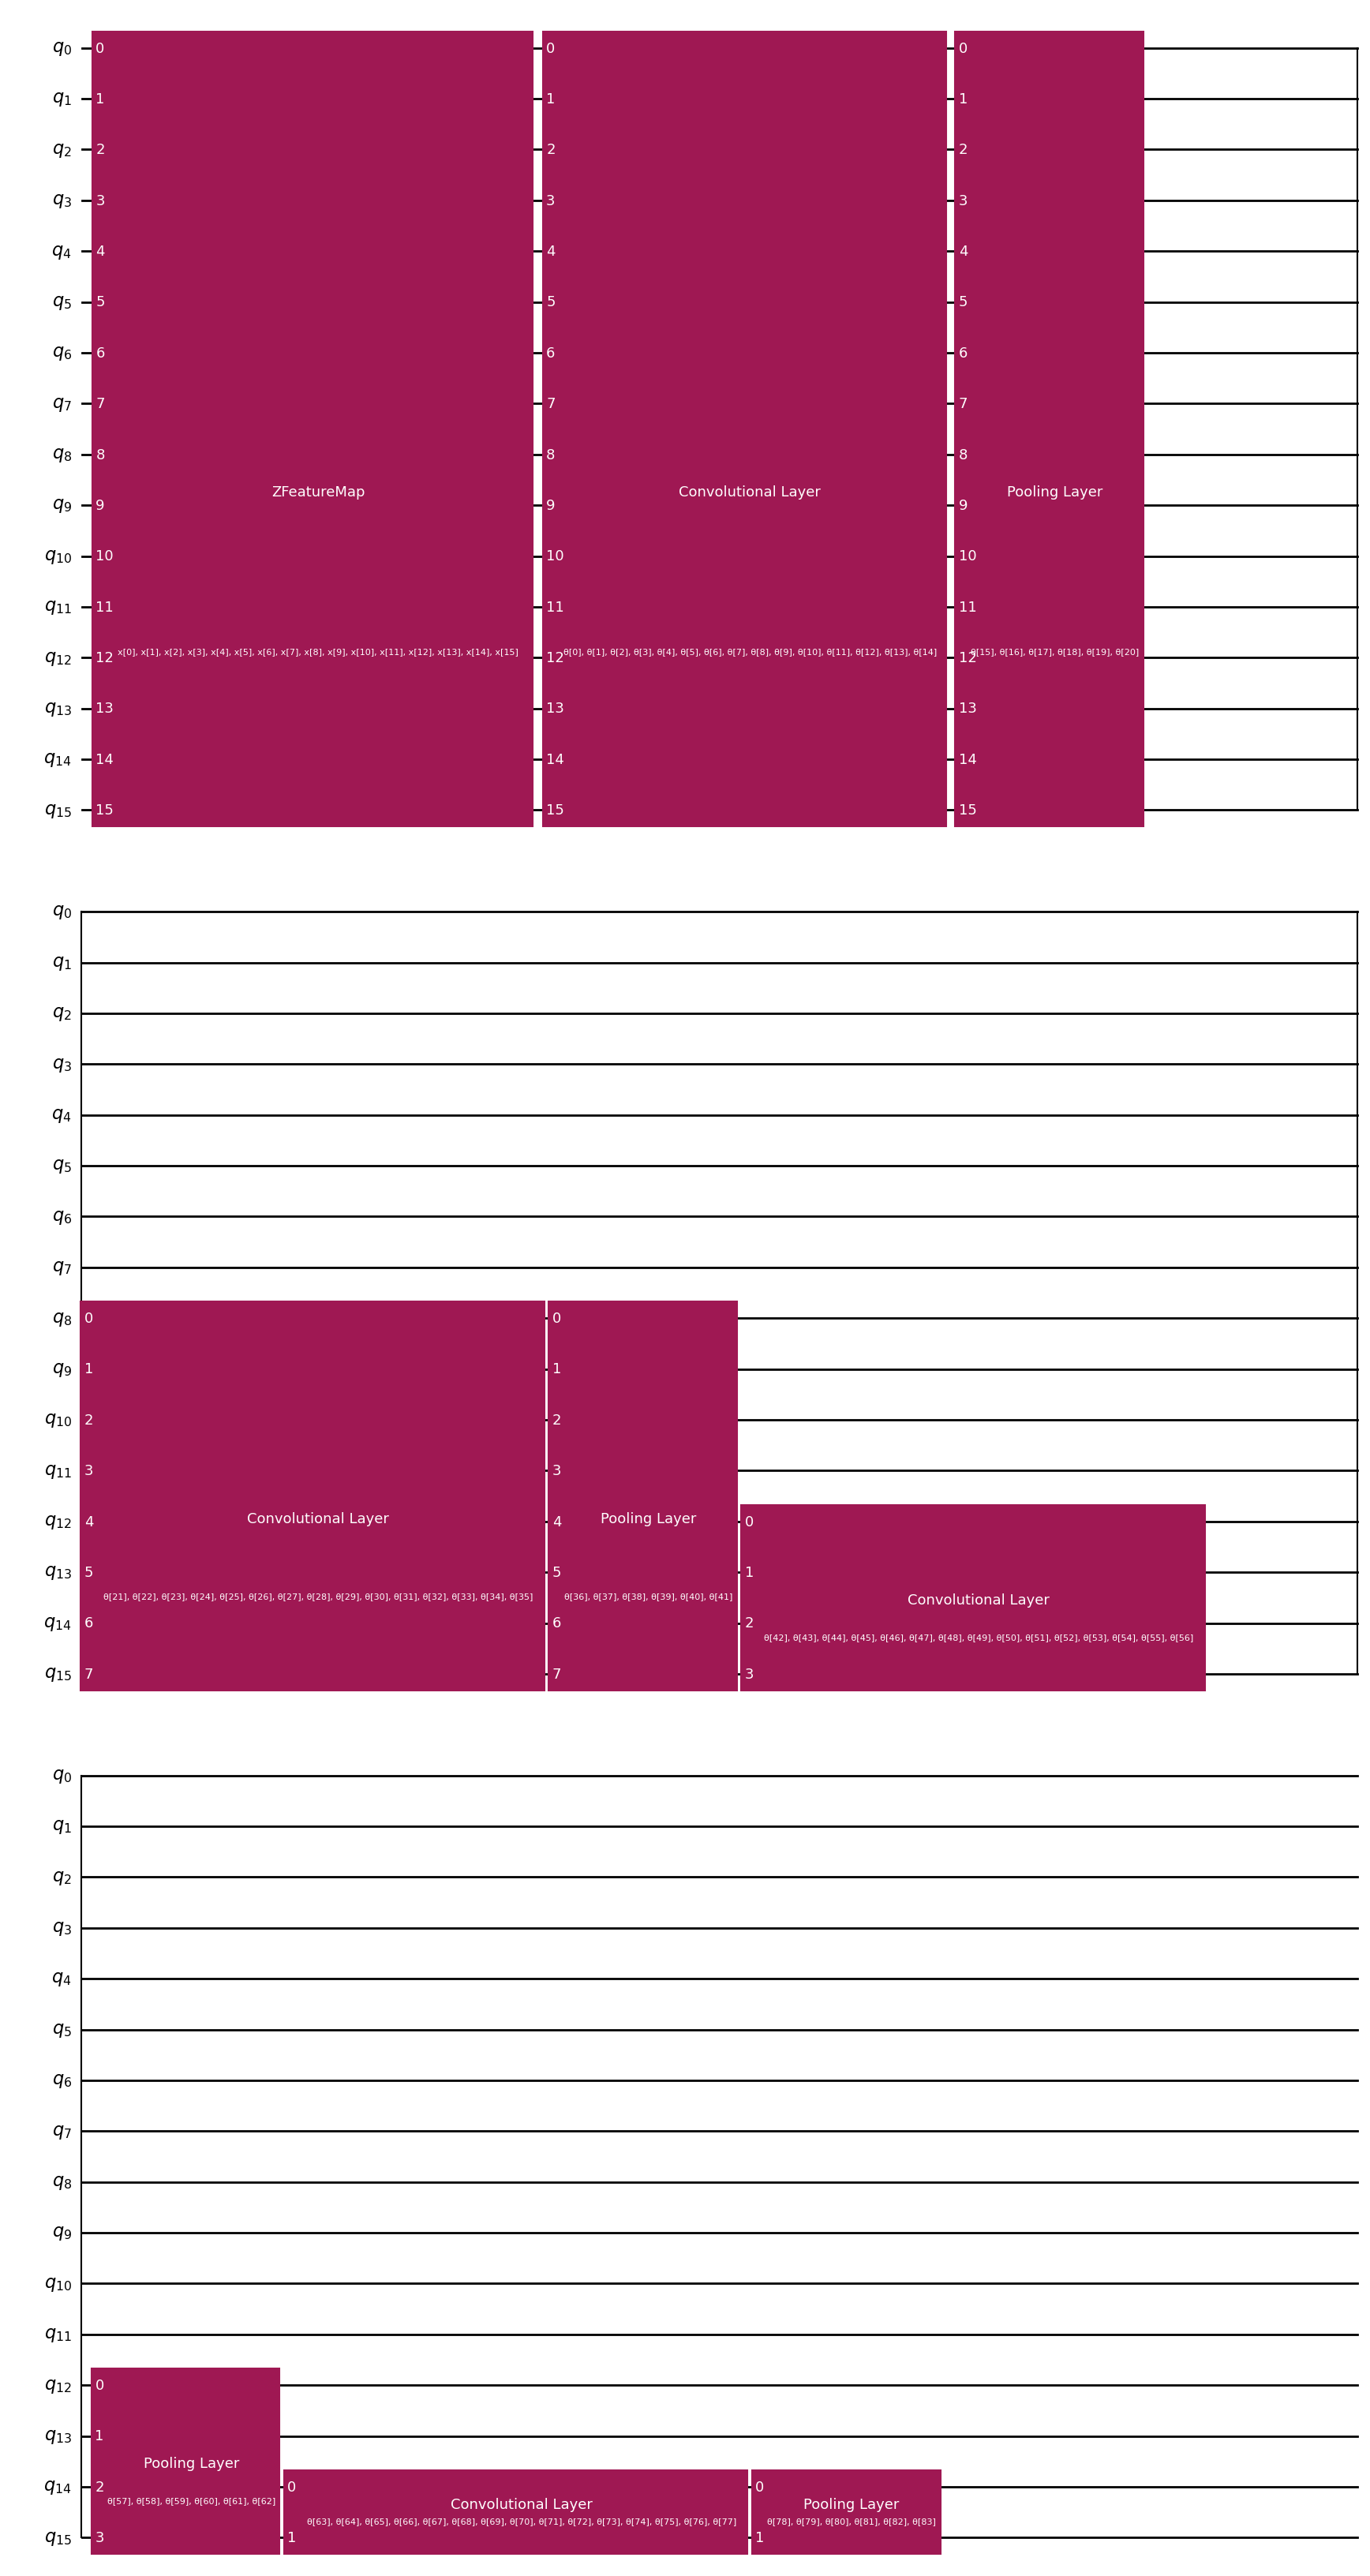

In [ ]:
ansatz = quantum_ansatz(n_qubits)

# Build the complete circuit by combining the feature map and the ansatz
circuit = QuantumCircuit(n_qubits)
circuit.compose(feature_map, range(n_qubits), inplace=True)
circuit.compose(ansatz, range(n_qubits), inplace=True)

circuit.draw("mpl", style="iqp")

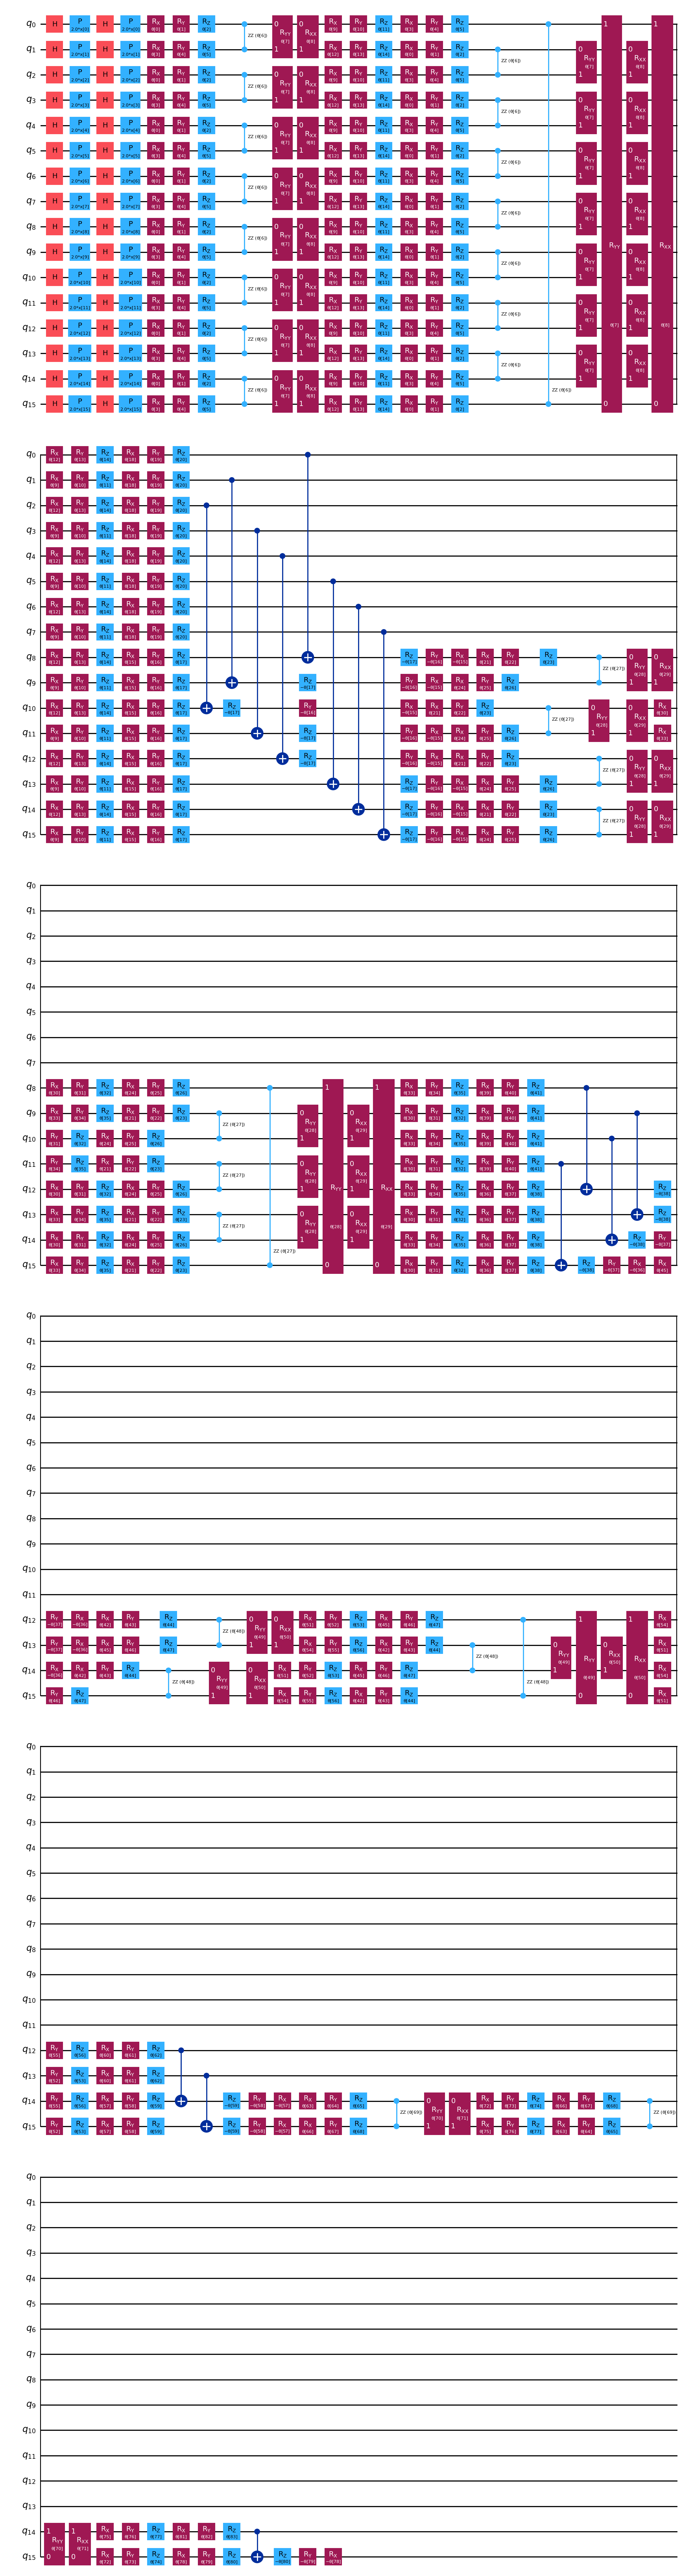

In [ ]:
circuit.decompose().draw("mpl", style="iqp")

In [ ]:
# Defines the output observable on the last qubit
observable = SparsePauliOp.from_list([("Z" + "I" * (n_qubits-1), 1)])

# Creates the QNN model using the EstimatorQNN
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

# 4. Entrenamiento

Se utiliza el método de optimización numérica [`COBYLA`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.COBYLA.html) para entrenar el [`Neural Network Classifier`](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkClassifier.html), usando los datos de entrenamiento y las etiquetas correspondientes para cada imagen.

La medición elegida es el valor esperado de la puerta de Pauli-Z para el último qubit: $\langle \hat{Z} \rangle$. Al medir este valor esperado, se obtiene +1 o -1, lo que corresponde a un 3 o un 6, respectivamente.


In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.figure(figsize=(12, 6))
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
checkpoint = "classifier.model"

if os.path.exists(checkpoint):
    classifier = NeuralNetworkClassifier.load(checkpoint)
    classifier.warm_start = True
    classifier.optimizer = COBYLA(maxiter=10)
    with open('objective_func_vals.pkl', 'rb') as file:
        objective_func_vals = pickle.load(file)
else:
    classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=COBYLA(maxiter=200),
        callback=callback_graph,
    )
    objective_func_vals = []

La función objetivo en este caso es el valor de la función de pérdida (es decir, `squared_error`) evaluada en las predicciones del modelo actual para los datos de entrenamiento.

In [ ]:
x = x_train_flatten
y = y_train_subset

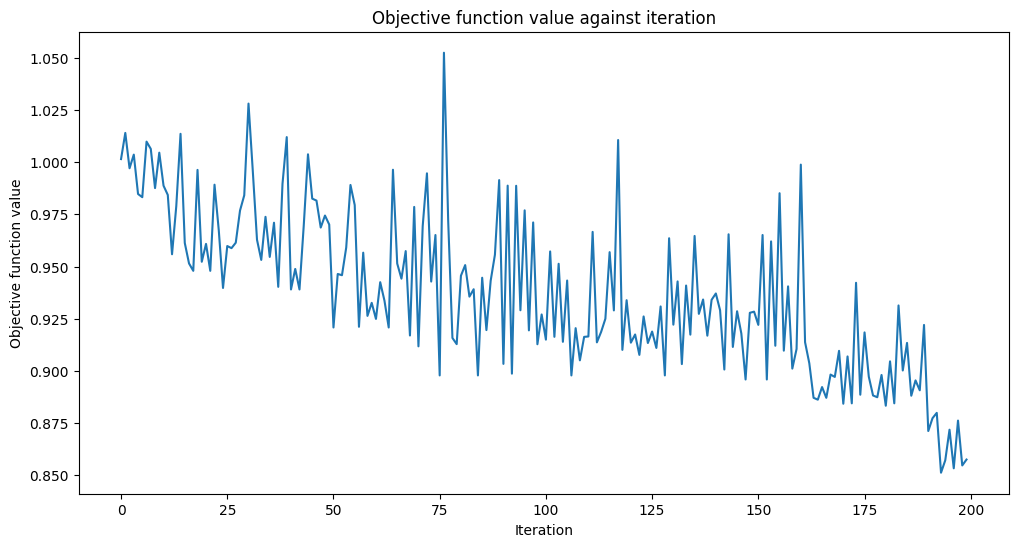

CPU times: user 1h 59min 46s, sys: 51min 47s, total: 2h 51min 34s
Wall time: 1h 43min 35s


In [ ]:
%%time
classifier.fit(x, y)

In [ ]:
classifier.save("classifier.model")

In [ ]:
with open('objective_func_vals.pkl', 'wb') as file:
    pickle.dump(objective_func_vals, file)

In [ ]:
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the train data : 90.0%


# 5. Pruebas

In [ ]:
x = x_test_flatten
y = y_test_subset

In [ ]:
y_predict = classifier.predict(x)

In [ ]:
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 80.0%


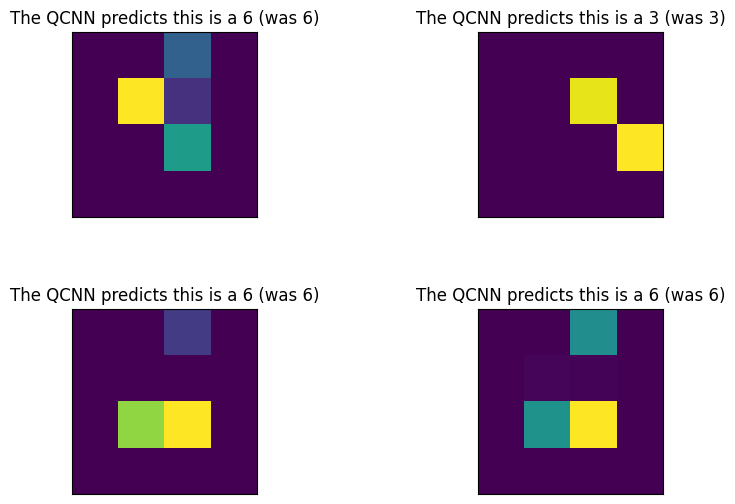

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x_test_subset[i][...,0], aspect="equal")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title(f"The QCNN predicts this is a {classes[0]} (was {classes[0] if y[i] == 1 else classes[1]})")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title(f"The QCNN predicts this is a {classes[1]} (was {classes[0] if y[i] == 1 else classes[1]})")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
for mode, x, y in zip(["Train", "Test"], [x_train_flatten, x_test_flatten], [y_train_subset, y_test_subset]):
    print(f"{mode:-^30}")

    y_true = y
    y_pred = classifier.predict(x)

    y_true_tensor = (tf.convert_to_tensor(y_true, dtype=tf.int32) + 1) / 2 #[-1,1] -> [0,1]
    y_pred_tensor = (tf.convert_to_tensor(y_pred, dtype=tf.int32) + 1) / 2 #[-1,1] -> [0,1]

    cm = tf.math.confusion_matrix(y_true_tensor, y_pred_tensor)

    print("Confusion Matrix:")
    print(cm.numpy())

    accuracy = tf.keras.metrics.Accuracy()
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    f1 = tf.keras.metrics.F1Score()

    accuracy.update_state(y_true_tensor, y_pred_tensor)
    precision.update_state(y_true_tensor, y_pred_tensor)
    recall.update_state(y_true_tensor, y_pred_tensor)
    f1.update_state(tf.reshape(y_true_tensor, [-1,1]), y_pred_tensor)

    print(f"Accuracy: {accuracy.result().numpy()}")
    print(f"Precision (positive class): {precision.result().numpy()}")
    print(f"Recall (positive class): {recall.result().numpy()}")
    print(f"F1 Score: {f1.result().numpy()}")

------------Train-------------
Confusion Matrix:
[[25  0]
 [ 5 20]]
Accuracy: 0.8999999761581421
Precision (positive class): 1.0
Recall (positive class): 0.800000011920929
F1 Score: [0.8888889]
-------------Test-------------
Confusion Matrix:
[[5 0]
 [2 3]]
Accuracy: 0.800000011920929
Precision (positive class): 1.0
Recall (positive class): 0.6000000238418579
F1 Score: [0.74999994]


# 6. Conclusión

Las QCNNs representan un enfoque prometedor en el campo del aprendizaje automático cuántico. Aunque se han propuesto modelos teóricos <a name="cite_ref-1"></a>[[1]](#cite_note-1), sigue existiendo un desafío significativo debido a la falta de hardware disponible capaz de implementar estos modelos <a name="cite_ref-8"></a>[[8]](#cite_note-8). Los enfoques híbridos que combinan capas cuánticas con métodos clásicos también enfrentan obstáculos <a name="cite_ref-4"></a>[[4]](#cite_note-4), particularmente en lo que respecta a la codificación, decodificación y medición, lo que limita el potencial del "speedup cuántico".

A pesar de estos desafíos, el uso del entrelazamiento en las QCNNs ha mostrado ser prometedor, ya que permite que los modelos generen predicciones y aprendan a partir de conjuntos de datos más pequeños. Los futuros avances en hardware cuántico, como el desarrollo de procesadores cuánticos a gran escala, podrían acelerar aún más el progreso. El aprendizaje profundo cuántico también está expandiéndose más allá del reconocimiento de imágenes hacia áreas como el procesamiento de lenguaje natural (NLP) <a name="cite_ref-9"></a>[[9]](#cite_note-9), lo que sugiere un futuro brillante para las QCNNs y el aprendizaje automático cuántico en general.

El aporte cuántico de esta arquitectura está enfocado en que las QCNN que utilizan una arquitectura MERA (Multi-scale Entanglement Renormalization Ansatz) requieren solo $O(\log(N))$ parámetros entrenables en los circuitos variacionales para una entrada de tamaño $N$ (tamaño del sistema), lo cual permite un entrenamiento mucho más eficiente con respecto a sus contraparte las CCNN <a name="cite_ref-1"></a>[[1]](#cite_note-1). También se las considera que son eficientemente simulables en esta era NISQ ya que utilizan circuitos variacionales, populares actualmente en los dispositivos cuánticos near-term (de corto alcance) <a name="cite_ref-10"></a>[[10]](#cite_note-10) <a name="cite_ref-12"></a>[[12]](#cite_note-12) <a name="cite_ref-15"></a>[[15]](#cite_note-15). Estos circuitos ejecutan secuencias cortas de puertas, ya que, debido a las limitaciones actuales de la tecnología cuántica (como la cantidad de qubits, la fidelidad de las puertas cuánticas, y la tasa de error), sin tolerancia a fallos, cada puerta aumenta el error del resultado <a name="cite_ref-13"></a>[[13]](#cite_note-13). Estudios como el de Oh et al. <a name="cite_ref-10"></a>[[10]](#cite_note-10) demostraron que las QCNN pueden mejorar la eficiencia del aprendizaje cuando se las compara con una red con solo capas fully-connected. También, las QCNN han sido usadas para resolver problemas en el campo de la física y la química, que no se resuelven de forma sencilla <a name="cite_ref-10"></a>[[10]](#cite_note-10). Finalmente, otra ventaja inherente del procesamiento de datos cuánticos, dejando por encima al modelo QCNN del modelo CNN clásico en esta perspectiva, es que traducir un estado cuántico complejo al mundo clásico puede enfrentar el problema conocido como “exponiential wall” <a name="cite_ref-13"></a>[[13]](#cite_note-13). Este problema hace referencia a la imposibilidad práctica de simular sistemas cuánticos complejos en una computadora clásica debido al crecimiento exponencial de los recursos necesarios.

Sin embargo, no todo es favorable en este aspecto, ya que existen problemas con respecto a las QCNN actuales. Entre ellos, es crucial resaltar que las QCNN requieren una excelente precisión numérica o recursos computacionales eficientes para mostrar sus ventajas sobre las CCNN <a name="cite_ref-13"></a>[[13]](#cite_note-13). Esto se debe a que comúnmente se compara la precisión de las predicciones entre el modelo cuántico y el clásico, donde un modelo específico puede no mostrar un excelente rendimiento en todas las tareas (esta perspectiva puede estar influenciada tanto por la tarea como por factores aleatorios). Por lo que se debe tener especial cuidado en las comparaciones, para tener en cuenta también los recursos computacionales utilizados durante el entrenamiento y la inferencia <a name="cite_ref-13"></a>[[13]](#cite_note-13).

En consecuencia, las QCNN no necesariamente muestran un rendimiento excelente en todas las tareas, en comparación con las CCNN, como se ha visto en trabajos de Oh et al. <a name="cite_ref-10"></a>[[10]](#cite_note-10) y Bermejo et al. <a name="cite_ref-14"></a>[[14]](#cite_note-14). En el primero ocurre que en la comparación ambas arquitecturas tienen una performance de aprendizaje muy similar ante un conjunto de datos trivial como lo es MNIST. En el segundo los autores demuestran empíricamente que son efectivas en problemas sencillos, con conjuntos de datos triviales, que pueden ser simulados clásicamente, pero no en problemas más complejos. De todas formas, ninguno de los autores descarta la posibilidad de su uso en computadoras cuánticas reales para mostrar sus verdaderas ventajas.

A medida que la investigación avanza en la intersección del aprendizaje profundo y la computación cuántica, podemos esperar más avances que ayuden a desbloquear todo el potencial de los modelos basados en cuántica como las QCNNs.



# 7. Bibliografía

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Cong, I., Choi, S., & Lukin, M. D. (2019). Quantum convolutional neural networks. Nature Physics, 15(12), 1273-1278.

* https://www.nature.com/articles/s41567-019-0648-8

<a name="cite_note-2"></a>2. [^](#cite_ref-2) The quantum convolution neural network - qiskit machine learning 0.7.2. (n.d.). Github.Io.

* https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html

<a name="cite_note-3"></a>3. [^](#cite_ref-3) LeCun, Y. (1998). The MNIST database of handwritten digits.

* http://yann.lecun.com/exdb/mnist/.

<a name="cite_note-4"></a>4. [^](#cite_ref-4) Lü, Y., Gao, Q., Lü, J., Ogorzałek, M., & Zheng, J. (2021). A quantum convolutional neural network for image classification (arXiv:2107.03630).

* https://arxiv.org/abs/2107.03630v1

<a name="cite_note-5"></a>5. [^](#cite_ref-5) Nielsen, M. A. (2006). Cluster-state quantum computation. Reports on Mathematical Physics, 57(1), 147-161.

* https://arxiv.org/abs/quant-ph/0504097

<a name="cite_note-6"></a>6. [^](#cite_ref-6) Vidal, G. (2008). Class of quantum many-body states that can be efficiently simulated. Physical review letters, 101(11), 110501.

* https://arxiv.org/abs/quant-ph/0610099

<a name="cite_note-7"></a>7. [^](#cite_ref-7) Tucci, R. R. (2005). An introduction to Cartan's KAK decomposition for QC programmers. arXiv preprint quant-ph/0507171.

* https://arxiv.org/abs/quant-ph/0507171

<a name="cite_note-8"></a>8. [^](#cite_ref-8) Garg, S., & Ramakrishnan, G. (2020). Advances in quantum deep learning: An overview. arXiv preprint arXiv:2005.04316.

* https://arxiv.org/abs/2005.04316

<a name="cite_note-9"></a>9. [^](#cite_ref-9) Galofaro, F., Toffano, Z., & Doan, B. L. (2018). Quantum semantic correlations in hate and non-hate speeches. arXiv preprint arXiv:1811.03275.

* https://arxiv.org/abs/1811.03275

<a name="cite_note-10"></a>10. [^](#cite_ref-10) Oh, S., Choi, J., & Kim, J. (2020, October). A tutorial on quantum convolutional neural networks (QCNN). In 2020 International Conference on Information and Communication Technology Convergence (ICTC) (pp. 236-239). IEEE.

* https://arxiv.org/abs/2009.09423

<a name="cite_note-11"></a>11. [^](#cite_ref-11) Quantum Convolutional Neural Network  :   tensorflow quantum. TensorFlow. (n.d.)

* https://www.tensorflow.org/quantum/tutorials/qcnn

<a name="cite_note-12"></a>12. [^](#cite_ref-12) Preskill, J. (2018). Quantum computing in the NISQ era and beyond. Quantum, 2, 79.

* https://quantum-journal.org/papers/q-2018-08-06-79/

<a name="cite_note-13"></a>13. [^](#cite_ref-13) Song, Y., Li, J., Wu, Y., Qin, S., Wen, Q., & Gao, F. (2024). A resource-efficient quantum convolutional neural network. Frontiers in Physics, 12, 1362690.

* https://www.frontiersin.org/journals/physics/articles/10.3389/fphy.2024.1362690/full

<a name="cite_note-14"></a>14. [^](#cite_ref-14) Bermejo, P., Braccia, P., Rudolph, M. S., Holmes, Z., Cincio, L., & Cerezo, M. (2024). Quantum convolutional neural networks are (effectively) classically simulable. arXiv preprint arXiv:2408.12739.

* https://arxiv.org/abs/2408.12739

<a name="cite_note-15"></a>15. [^](#cite_ref-15)  Quantum Convolutional Neural Networks — PennyLane. (n.d.).

* https://pennylane.ai/qml/glossary/qcnn